<a href="https://colab.research.google.com/github/endernac/CV-Final-Project/blob/main/people_detector_distancing_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sk-video

     |████████████████████████████████| 2.3MB 19.7MB/s 


In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import cv2
import skvideo.io
import numpy as np

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load in the video and homography

In [3]:
def load_homography(fname):
  """ Load a homography from a text file """
  return np.loadtxt(fname, delimiter=',')

# load video into a generator of images
def v2i(filename, scale=1):
    cap = cv2.VideoCapture(filename)
    while(True):
        ret, frame = cap.read()
        if ret: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (frame.shape[1] // scale, frame.shape[0] // scale))
            yield frame
        else: break

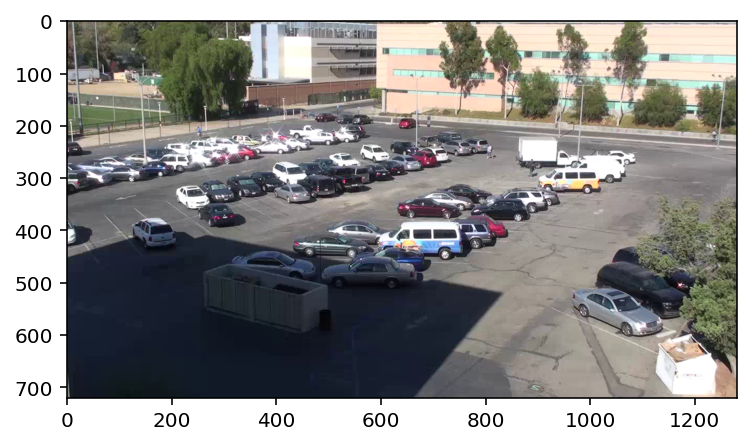

In [4]:
# load the video
vid_path = 'gdrive/MyDrive/3. Senior Year/CV/CV Final Project/videos/VIRAT_S_010111_08_000920_000954.mp4'
scale = 1
video = v2i(vid_path, scale)
frame0 = next(video)
plt.imshow(frame0, cmap='gray')

In [5]:
# load the homography - predefined
homog_path = 'gdrive/MyDrive/3. Senior Year/CV/CV Final Project/homographies/VIRAT_0101_homography_img2world.txt'
H = load_homography(homog_path)

print(H)

[[-2.9320106e-04  1.2073065e-03 -5.9184241e-01]
 [ 5.0597447e-04  9.6643864e-04 -8.0604973e-01]
 [ 7.7224635e-08 -4.5847150e-05  2.0273329e-03]]


In [6]:
# Do not run this box to use a predefined homography
# This is a homography that was found manually
H = np.array([[-3.60000092e-01, -8.47059041e-01,  4.76873064e+02],
              [-1.49786927e-01,  8.54666584e-01, -2.10794261e+02],
              [-3.03477216e-04, -1.61309873e-02,  1.00000000e+00]])

# Tune parameters for the output video

In [7]:
def trans_mat(xoffset, yoffset):
  """ Create a translation matrix"""
  return np.array([[1, 0, xoffset],
                  [0, 1, yoffset],
                  [0, 0, 1]])

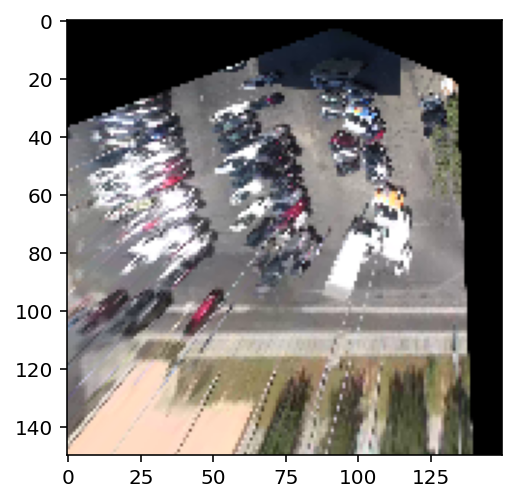

In [8]:
img = frame0.copy()
imgsize = (150, 150)   # how large the resultant image should be
translation = trans_mat(80, 40)  # shift it so it is in frame

preview_img = cv2.warpPerspective(img, translation @ H, imgsize)
plt.imshow(preview_img)

# Determine Camera Pose

In [9]:
def get_k_mat(fx, fy, ox, oy):
  """ Get the intrinsic matrix parameters """
  return np.array([[fx, 0, ox], [0, fy, oy], [0, 0, 1]])

"""
Since we are determining scale later on, we can arbitrarily determine our
intrinsic matrix focal lengths. Focal lengths just serve as scaling factors,
so it is not necessary to figure out the exact ones (although it would be 
helpful and make this task easier overall)
"""
fx = 100
fy = 100
height, width, channels = frame0.shape
ox = (int) (width / 2)
oy = (int)(height / 2)
K = get_k_mat(fx, fy, ox, oy)

In [10]:
def qx_to_theta(Qx):
  """ For rotation matrix Qx, get the theta out of it in radians"""
  temp = Qx[1, 1]  # gives cos(theta)
  #return np.degrees(np.arccos(np.radians(temp)))
  return np.arccos(temp)

def qy_to_theta(Qy):
  """ For rotation matri Qy, get the theta out of it in radians"""
  temp = Qy[1, 1]
  #return np.degrees(np.arccos(np.radians(temp)))
  return np.arccos(temp)

def qz_to_theta(Qz):
  """ For a rotation matrix Qz, get the theta out of it in radians"""
  temp = Qz[1, 1]
  #return np.degrees(np.arccos(np.radians(temp)))
  return np.arccos(temp)

In [11]:
"""
Recover candidate rotations and translations.
This usually returns 4 poses. Apparently, 2 of them are in front of or behind.
For now, we can manually inspect them.
TODO: autommatically determine the best or apply some constraint?
"""
retval, rotations, translations, normals = cv2.decomposeHomographyMat(H, K)

"""
Decompose into the rotation matrices about certain axes.
This generally returns a 0 for x or y. This is becauese the z rotation
can be arbitrarily defined as long as we are confident in our x or y rotations.
"""
Qxs = []
Qys = []
Qzs = []
for index, rot in enumerate(rotations):
  retval, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rot)
  Qxs.append(Qx)
  Qys.append(Qy)
  Qzs.append(Qz)
  print('Rotation ' + str(index) + ':')
  print(np.degrees(qx_to_theta(Qx)))
  print(np.degrees(qy_to_theta(Qy)))
  print(np.degrees(qz_to_theta(Qz)))
  print('\n')
  
### Allow user input to determine elevation angle
# Note: this angle is the amount that the camera is rotated, but we're
#       eventually going to want to do 90 - elevation, or 180 - elevatino
#       depending on the pose
idx = input('Enter index of desired rotation')
idx = int(idx)
elevation_angle = np.degrees(qx_to_theta(Qxs[idx]))
print(elevation_angle)

Rotation 0:
17.11396594543072
0.0
33.08699091756533


Rotation 1:
17.11396594543072
0.0
33.08699091756533


Rotation 2:
160.99830807970207
0.0
152.40952488544107


Rotation 3:
160.99830807970207
0.0
152.40952488544107


Enter index of desired rotation0
17.11396594543072


# Detection Pipeline

In [12]:
# load the model
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();
model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


In [13]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b

In [14]:
# utilities for determining location of head/feet in image
def getFeet(boxes, prob):
  """ Get all foot locations"""
  feet = []
  
  for p, (xc, yc, w, h) in zip(prob, boxes.tolist()):
    cl = p.argmax()
    if cl == 1:
      x = int(xc)
      y = int(yc + h/2)
      feet.append((x, y))

  return feet

def get_heads_and_feet(boxes, prob):
  """ Get location of feet and heads.
  Returns everything as homogenous coordinates"""
  heads = []
  feet = []
  
  for p, (xc, yc, w, h) in zip(prob, boxes.tolist()):
    cl = p.argmax()
    if cl == 1:
      x = int(xc)
      y_head = int(yc - h/2)
      y_feet = int(yc + h/2)
      feet.append(np.array([x, y_feet, 1]))
      heads.append(np.array([x, y_head, 1]))

  return feet, heads

In [15]:
# utiliies for projecting points in the images
def image_to_bird(coord, H):
    """ 
    Given coords in the form (xi, yi, 1) and the image-->bird homography, return the birds eye view coords
    """
    pt_bird = H @ coord
    pt_bird = pt_bird / pt_bird[2]
    return pt_bird

def calculate_homography_scale(coord_bot, coord_top, H, elevation, avg_height=5.3):
  # project those points into world space
  feet_img_coord = image_to_bird(coord_bot, H)
  head_img_coord = image_to_bird(coord_top, H)

  # determine the disstance between head and feet in homography space
  ground_in_H_space = np.sqrt( (feet_img_coord[0] - head_img_coord[0] )**2 
                            + (feet_img_coord[1] - head_img_coord[1])**2)

  # calculate what that distance should be in feet
  alpha = 90 - elevation
  ground_in_feet = avg_height * np.tan(np.radians(alpha))
  #print('Distance between the 2 points in feet = {}'.format(ground_in_feet))
  #print('Distance between the 2 points in H space = {}'.format(ground_in_H_space))
  feet_per_unit = ground_in_feet / ground_in_H_space
  return feet_per_unit

In [16]:
def distance(x1, x2, y1, y2):
  return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [23]:
# run the main pipeline
vidcap = cv2.VideoCapture(vid_path)
success, image = vidcap.read()
img_w, img_h = (image.shape[1], image.shape[0])
tracking = []  # array to store final video
birds_images = []  # array to store birds eye view

# loop parameters
count = 0            # number of frames processes
scale_factor = 0     # scale to access outside of loop
social_distance = 6  # social distance in feet
color = (0, 0, 255)  # color of circle
thickness = 1        # thickness of circle line


while success:
  ########## DETR Detection ###########
  # copy image for display 
  img_copy = image.copy()

  # convert image to tensor for computations
  img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  img = transform(img).unsqueeze(0).cuda()

  # propagate through the model
  outputs = model(img)

  # keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # TODO: phase out double detections?

  # convert tensors to numpy
  boxes_scaled = outputs['pred_boxes'][0, keep].cpu().numpy() * np.array([img_w, img_h, img_w, img_h])
  probas_np = probas.cpu().numpy()

  ############ Feet detection ###############
  # get the coordinates of everyone's feet
  feet = getFeet(boxes_scaled, probas[keep])

  # plot everyone's feet
  for person in feet:
    img_copy = cv2.circle(img_copy, person, 5, (255,0,0), -1)

  tracking.append(img_copy)

  ############ Find the Bird's Eye View Scale ###############
  feet_temp, heads_temp = get_heads_and_feet(boxes_scaled, probas[keep])
  if feet != [] and scale_factor == 0:
    print('Calculating orientation')
    # Pick the first items in the lists for simplicity
    # Hopefully they are good candidates near middle of image
    selected_foot = feet_temp[1]
    selected_head = heads_temp[1]

    # Determine elevation angle
    scale_factor = calculate_homography_scale(selected_foot,
                                              selected_head,
                                              H,
                                              elevation_angle)
    print(scale_factor)
  
  ####### Output as Bird's Eye View ###############
  # if we have already determined a scale factor, begin drawing circles
  if scale_factor != 0:  
    b_img = cv2.warpPerspective(image.copy(), translation @ H, imgsize)
    H_radius = 1/scale_factor * social_distance

    for foot in feet_temp:  # draw a circle for all the feet
      bird_coord = image_to_bird(foot, translation @ H)
      b_img = cv2.circle(b_img, 
                         ((int)(bird_coord[0]), (int)(bird_coord[1])), 
                         (int)(H_radius), 
                         color, 
                         thickness)

    for foot1 in feet_temp:
      for foot2 in feet_temp:
        f1 = image_to_bird(foot1, translation @ H)
        f2 = image_to_bird(foot2, translation @ H)
        x1, x2 = f1[0], f2[0]
        y1, y2 = f1[1], f2[1]

        # get distance
        if np.all(f1 != f2) and distance(x1, x2, y1, y2) < (6 / scale_factor):
          b_img = cv2.circle(b_img, 
                         ((int)(f1[0]), (int)(f1[1])), 
                         (int)(H_radius), 
                         (255, 0, 0), 
                         thickness)
          b_img = cv2.circle(b_img, 
                         ((int)(f2[0]), (int)(f2[1])), 
                         (int)(H_radius), 
                         (255, 0, 0), 
                         thickness)

    birds_images.append(b_img)
  else:
    b_img = cv2.warpPerspective(image.copy(), translation @ H, imgsize)
    birds_images.append(b_img)


  success,image = vidcap.read()
  count += 1

  # break condition to exit a little early
  #if count == 48:
  #  break

tracking = np.array(tracking)
birds_images = np.array(birds_images)
print("great success!!")

Calculating orientation
1.5002085262674558
great success!!


### Display in browser

In [ ]:
# Video with tracking markers
from IPython.display import HTML
from base64 import b64encode
skvideo.io.vwrite("outputvideo.mp4", tracking)

mp4 = open('outputvideo.mp4','rb').read()
data_url = "data:outputvideo/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [24]:
# Video with circles around feet
from IPython.display import HTML
from base64 import b64encode
skvideo.io.vwrite("birdvideo.mp4", birds_images)

mp4 = open('birdvideo.mp4','rb').read()
data_url = "data:birdvideo/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Write to file format that Windows can read

In [ ]:
# Write output - tracking markers on feet version
height, width, channels = tracking[0].shape

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
out = cv2.VideoWriter('output.mp4',fourcc,fps,(width,height))
for i in range(len(tracking)):
  out.write(tracking[i])
out.release()

In [ ]:
# Write output - birds eye view version
height, width, channels = birds_images[0].shape

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
out = cv2.VideoWriter('birdvideo.mp4',fourcc,fps,(width,height))
for i in range(len(birds_images)):
  out.write(birds_images[i])
out.release()